<a href="https://colab.research.google.com/github/carlosmvond/hybrid-modelling-of-batch-bioreactors/blob/main/Application_1_Ecoli_2026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This first code block is used to generate synthetic data using the model developed by Mauri et al. (2020). It is important to note that we consider the version of the model without recombinant protein production.

Mauri, M., Gouzé, J. L., De Jong, H., & Cinquemani, E. (2020). Enhanced production of heterologous proteins by a synthetic microbial community: Conditions and trade-offs. PLOS Computational Biology, 16(4), e1007795.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# === Model parameters (batch, Yh = 0) ===
kg      = 1.53
Kg      = 0.09
Theta_a = 0.52
n       = 1
k_over  = 0.17
l       = 0.7
ka      = 0.97
Ka      = 0.5
Theta_g = 0.25
m_CCR   = 1
Yg      = 0.44
Ya      = 0.298
kdeg    = 0.0044

# === Kinetics ===
def r_gup(G, A):
    """Glucose uptake rate."""
    return kg * G/(G + Kg) * (Theta_a**n)/(A**n + Theta_a**n)

def r_a_up(G, A):
    """Acetate uptake rate with CCR."""
    return ka * A/(A + Ka) * 1/(1 + (r_gup(G, A)/Theta_g)**m_CCR)

def r_a_over(G, A):
    """Overflow acetate production when glucose uptake exceeds threshold l."""
    return k_over * max(0, r_gup(G, A) - l)

# === Batch model ODEs ===
def ode_batch(t, y):
    """
    States:
      X: biomass
      G: glucose
      A: acetate
    """
    X, G, A = y
    rg  = r_gup(G, A)
    rau = r_a_up(G, A)
    ro  = r_a_over(G, A)
    dX = (Yg*rg + Ya*(rau - ro)) * X - kdeg * X
    dG = - rg * X
    dA = (ro - rau) * X
    return [dX, dG, dA]

# === Generate "clean" synthetic data ===
time_points = np.linspace(0, 15, 10)
initial_glucose = [10, 20, 35, 50, 5, 15, 25, 30, 40, 45]
X0 = 0.1

raw_t, raw_X, raw_G, raw_A = [], [], [], []

for G0 in initial_glucose:
    sol = solve_ivp(
        ode_batch,
        (time_points[0], time_points[-1]),
        [X0, G0, 0.0],
        t_eval=time_points
    )
    raw_t.append(sol.t.tolist())
    raw_X.append(sol.y[0].tolist())
    raw_G.append(sol.y[1].tolist())
    raw_A.append(sol.y[2].tolist())

# === Configurable multiplicative noise ===
# Coefficient of variation (relative std): typically 0.02–0.2
cv_X = 0.05  # biomass
cv_G = 0.05  # glucose
cv_A = 0.05  # acetate

# Factor for t = 0 (use <1.0 to reduce noise on initial conditions)
init_scale = 0.5  # 0.5 = half the noise on the first point; use 1.0 for the same as others

rng = np.random.default_rng(12345)

def add_multiplicative_noise(series_2d, cv, init_scale=1.0, clip_min=0.0):
    """
    Apply y_obs = y * (1 + N(0, cv)) pointwise.
    The first point is scaled by 'init_scale' to optionally reduce initial noise.
    """
    out = []
    for row in series_2d:
        row = np.asarray(row, dtype=float)
        eps = rng.normal(0.0, cv, size=row.shape)
        eps[0] *= init_scale
        y_obs = row * (1.0 + eps)
        if clip_min is not None:
            y_obs = np.maximum(y_obs, clip_min)
        out.append(y_obs.tolist())
    return out

# Observed data with multiplicative noise
obs_X = add_multiplicative_noise(raw_X, cv_X, init_scale=init_scale, clip_min=0.0)
obs_G = add_multiplicative_noise(raw_G, cv_G, init_scale=init_scale, clip_min=0.0)
obs_A = add_multiplicative_noise(raw_A, cv_A, init_scale=init_scale, clip_min=0.0)

# === Utility: pretty-print 2D lists ===
def print_list(name, data):
    print(f"{name} = [")
    for row in data:
        print("    [" + ", ".join(f"{x:.4f}" for x in row) + "],")
    print("]\n")

# Print noisy data (switch to raw_* if you want clean data)
print_list("raw_t", raw_t)
print_list("obs_X", obs_X)
print_list("obs_G", obs_G)
print_list("obs_A", obs_A)


raw_t = [
    [0.0000, 1.6667, 3.3333, 5.0000, 6.6667, 8.3333, 10.0000, 11.6667, 13.3333, 15.0000],
    [0.0000, 1.6667, 3.3333, 5.0000, 6.6667, 8.3333, 10.0000, 11.6667, 13.3333, 15.0000],
    [0.0000, 1.6667, 3.3333, 5.0000, 6.6667, 8.3333, 10.0000, 11.6667, 13.3333, 15.0000],
    [0.0000, 1.6667, 3.3333, 5.0000, 6.6667, 8.3333, 10.0000, 11.6667, 13.3333, 15.0000],
    [0.0000, 1.6667, 3.3333, 5.0000, 6.6667, 8.3333, 10.0000, 11.6667, 13.3333, 15.0000],
    [0.0000, 1.6667, 3.3333, 5.0000, 6.6667, 8.3333, 10.0000, 11.6667, 13.3333, 15.0000],
    [0.0000, 1.6667, 3.3333, 5.0000, 6.6667, 8.3333, 10.0000, 11.6667, 13.3333, 15.0000],
    [0.0000, 1.6667, 3.3333, 5.0000, 6.6667, 8.3333, 10.0000, 11.6667, 13.3333, 15.0000],
    [0.0000, 1.6667, 3.3333, 5.0000, 6.6667, 8.3333, 10.0000, 11.6667, 13.3333, 15.0000],
    [0.0000, 1.6667, 3.3333, 5.0000, 6.6667, 8.3333, 10.0000, 11.6667, 13.3333, 15.0000],
]

obs_X = [
    [0.0964, 0.2917, 0.6666, 1.5951, 3.4965, 4.2735, 4.1042, 4.5152, 4.4197, 

This code visualizes the synthetic batch data generated with the Mauri et al. (2020) model.
It produces a grid of plots showing the time evolution of biomass (X), glucose (G), and acetate (A) for each simulated batch experiment.

Each subplot corresponds to one batch, identified by its initial glucose concentration (G₀).

*   The left y-axis displays biomass (X) and glucose (G).
*   The right y-axis displays acetate (A).
*   Observed data (with noise) are shown with dashed lines and markers.

Global minimum and maximum values are computed so that all subplots share consistent axis limits, facilitating comparison across experiments.

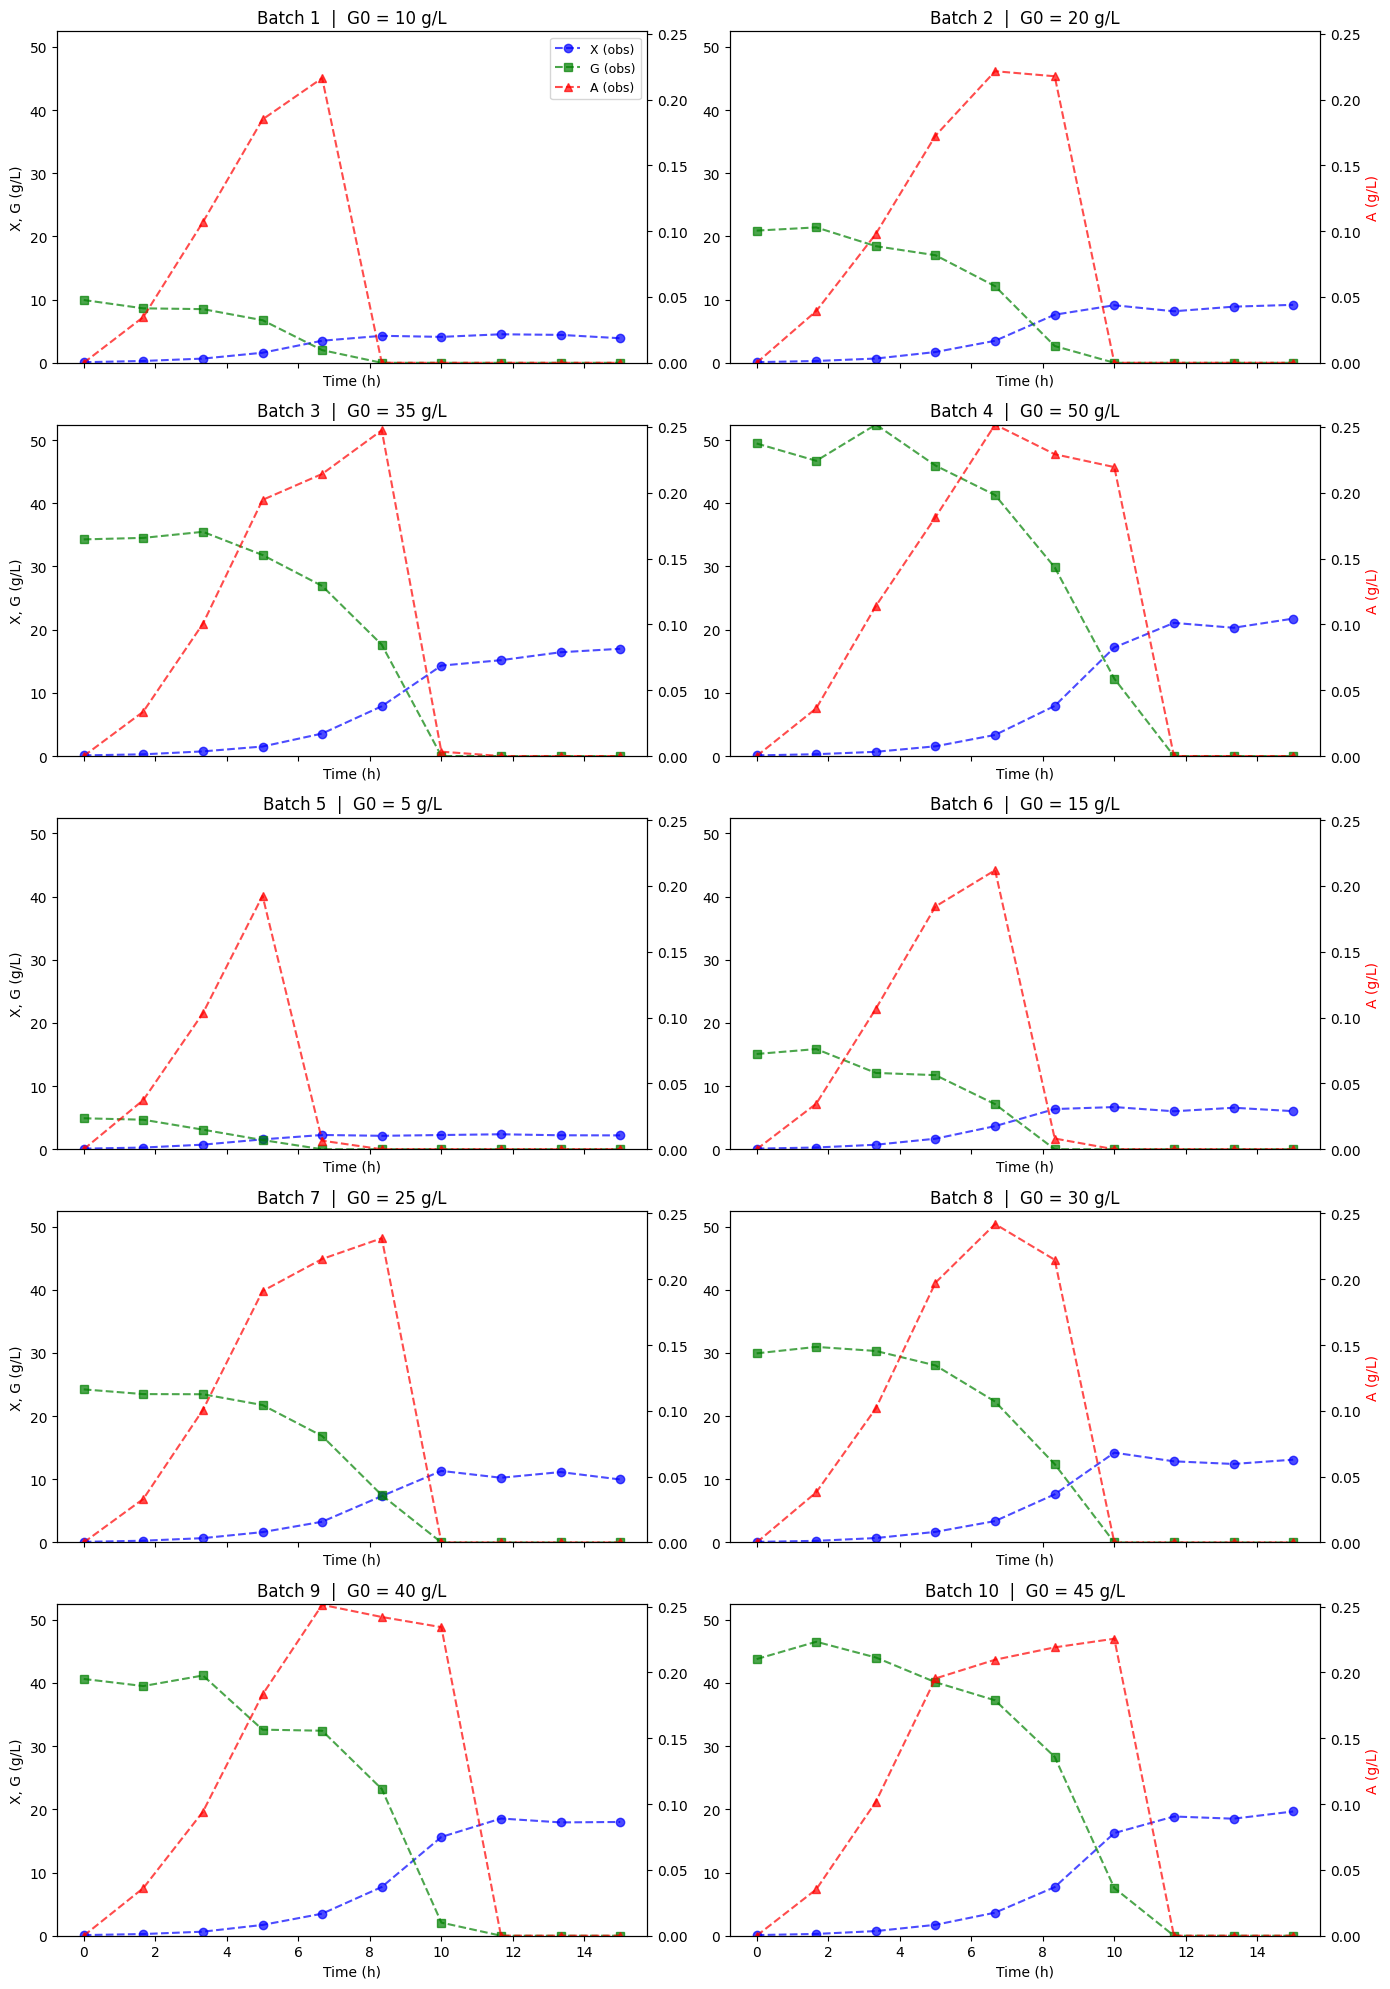

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Compute global min/max for consistent y-axes ---
X_all = np.concatenate([np.array(x) for x in obs_X])
G_all = np.concatenate([np.array(g) for g in obs_G])
A_all = np.concatenate([np.array(a) for a in obs_A])

ymin_XG = min(X_all.min(), G_all.min())
ymax_XG = max(X_all.max(), G_all.max())

ymin_A = A_all.min()
ymax_A = A_all.max()

# --- Figure: 2 rows × 2 cols (4 batches) ---
n_batches = len(initial_glucose)
fig, axes = plt.subplots(5, 2, figsize=(14, 20), sharex=True)
axes = axes.flatten()

for i, (G0, t, X_true, G_true, A_true, X_obs, G_obs, A_obs) in enumerate(
    zip(initial_glucose, raw_t, raw_X, raw_G, raw_A, obs_X, obs_G, obs_A)
):
    ax1 = axes[i]
    ax2 = ax1.twinx()

    # X (blue) and G (green) on left axis
    ax1.plot(t, X_obs, 'b--', marker='o', alpha=0.7, label='X (obs)')
    ax1.plot(t, G_obs, 'g--', marker='s', alpha=0.7, label='G (obs)')
    ax1.set_xlabel("Time (h)")
    ax1.set_ylim(ymin_XG, ymax_XG)
    if i % 2 == 0:  # first column
        ax1.set_ylabel("X, G (g/L)")

    # A (red) on right axis
    ax2.plot(t, A_obs, 'r--', marker='^', alpha=0.7, label='A (obs)')
    ax2.set_ylim(ymin_A, ymax_A)
    if i % 2 == 1:  # last column
        ax2.set_ylabel("A (g/L)", color='r')

    # Title with Batch number + G0
    ax1.set_title(f"Batch {i+1}  |  G0 = {G0} g/L")

    # Merge legends (only on first subplot to avoid clutter)
    if i == 0:
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right", fontsize=9)

# Hide any extra axes if present
for j in range(n_batches, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


### ⚙️ Hybrid model calibration

The following code trains the **hybrid model** to the synthetic data generated earlier.  

The model has the following structure:

$$
\begin{aligned}
\frac{dX}{dt} &= f_{1}(\cdot)\,X, \\[6pt]
\frac{dG}{dt} &= f_{2}(\cdot)\,G\,X, \\[6pt]
\frac{dA}{dt} &= \big(f_{3}(\cdot)\,A + g_{3}(\cdot)\big)\,X.
\end{aligned}
$$

The functions  $f_i$, $i=1,2,3$ and $g_3$ form the **output layer** of the neural network. The activation function in the output layer is the **identity** for $f_i$ and **ReLU** for \( g_3 \).

---

### 🔧 Algorithm configuration

The algorithm is configured at the beginning of the code.  
The main **hyperparameters and options** are defined at the start of the script:

- **TRAIN_MODE** (`"batch"` | `"global"`):  
  - `"batch"`: each batch experiment is treated as an independent mini-batch; parameters are updated multiple times per epoch.  
  - `"global"`: the loss from all batches is accumulated, and a single update is performed per epoch (equivalent to one large global batch).

- **LR** (learning rate):  
  Update step size for the Adam optimizer. High values may destabilize training; low values may slow convergence.

- **NUM_EPOCHS:**  
  Number of complete passes through the training set.

- **DROPOUT_RATE_HIDDEN:**  
  Fraction of hidden neurons randomly turned off during training (standard dropout, disabled during evaluation).   Useful for regularization and, optionally, for estimating uncertainty via Monte Carlo dropout.

- **EPS:**  
  Small positive constant used to stabilize divisions in the loss function (prevents division by zero). A typical value is \(10^{-8}\).

- **SEED:**  
  Master random seed for reproducibility (affects initialization and dropout masks). It does not guarantee identical results across hardware, but reduces variability.

- **N_SEED:**  
  Number of initialization. By default is set to 10.

---

### 🧠 MLP architecture

Defined by `hidden_layers` and `layer_sizes` (e.g., `3-5-5-5-4`),  where **3** is the input dimension, **4** is the output dimension, and the intermediate values correspond to the hidden layers.

---



RUNNING SEED 1 (1/10)
[Init calib] step 0, loss=6.2867e-03
[Init calib] step 50, loss=2.7244e-04
[Init calib] step 100, loss=7.1983e-05
[Init calib] step 150, loss=2.1755e-05
[Init calib] step 200, loss=8.7330e-06
[Init calib] step 250, loss=4.2669e-06
[Init calib] step 300, loss=2.3342e-06
[Init calib] step 350, loss=1.3987e-06
[Init calib] step 400, loss=9.0318e-07
[Init calib] step 450, loss=6.0345e-07
[Init calib] step 500, loss=4.8822e-07
[Init calib] step 550, loss=4.0914e-07
[Init calib] step 600, loss=3.3859e-07
[Init calib] step 650, loss=2.7897e-07
[Init calib] step 700, loss=2.6624e-07
[Init calib] step 750, loss=2.1862e-07
[Init calib] step 800, loss=1.8237e-07
[Init calib] step 850, loss=1.6085e-07
[Init calib] step 900, loss=1.4546e-07
[Init calib] step 950, loss=1.4434e-07
[Seed 1 | Global] Epoch 50, train=3.185250, valid=3.459208
[Seed 1 | Global] Epoch 100, train=1.024405, valid=1.167341
[Seed 1 | Global] Epoch 150, train=0.729691, valid=0.948645
[Seed 1 | Global] Epo

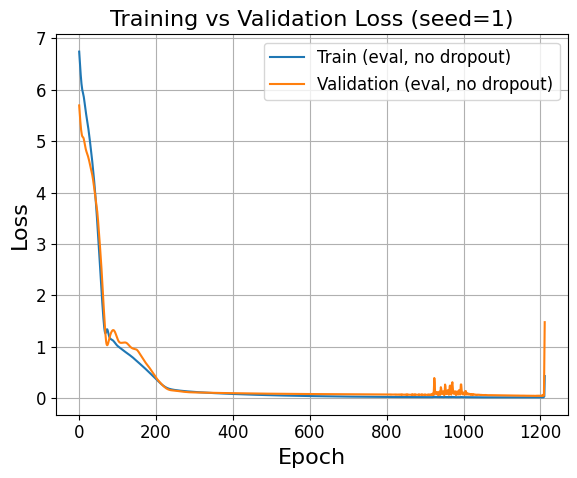

[Seed 1] cpu_time=305.081s, wall_time=291.120s, best_val=4.836780e-02 @ epoch 1189
--> NEW GLOBAL BEST: seed=1, best_val=4.836780e-02 at epoch 1189

RUNNING SEED 2 (2/10)
[Init calib] step 0, loss=1.9949e-02
[Init calib] step 50, loss=1.5983e-03
[Init calib] step 100, loss=1.3672e-04
[Init calib] step 150, loss=8.1729e-05
[Init calib] step 200, loss=5.7427e-05
[Init calib] step 250, loss=4.1192e-05
[Init calib] step 300, loss=2.9815e-05
[Init calib] step 350, loss=2.1711e-05
[Init calib] step 400, loss=1.6047e-05
[Init calib] step 450, loss=1.2174e-05
[Init calib] step 500, loss=9.5282e-06
[Init calib] step 550, loss=7.4274e-06
[Init calib] step 600, loss=5.9981e-06
[Init calib] step 650, loss=4.7999e-06
[Init calib] step 700, loss=3.8527e-06
[Init calib] step 750, loss=3.1338e-06
[Init calib] step 800, loss=2.5863e-06
[Init calib] step 850, loss=2.1900e-06
[Init calib] step 900, loss=1.7717e-06
[Init calib] step 950, loss=1.5160e-06
[Seed 2 | Global] Epoch 50, train=4.693166, valid=4.

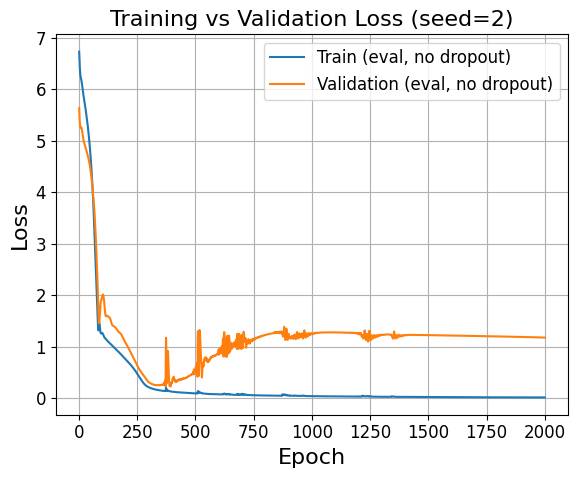

[Seed 2] cpu_time=313.593s, wall_time=337.905s, best_val=2.328762e-01 @ epoch 393

RUNNING SEED 3 (3/10)
[Init calib] step 0, loss=1.0508e-02
[Init calib] step 50, loss=2.0097e-04
[Init calib] step 100, loss=5.1982e-05
[Init calib] step 150, loss=3.1656e-05
[Init calib] step 200, loss=2.0541e-05
[Init calib] step 250, loss=1.4074e-05
[Init calib] step 300, loss=1.0045e-05
[Init calib] step 350, loss=7.6775e-06
[Init calib] step 400, loss=6.2579e-06
[Init calib] step 450, loss=4.9636e-06
[Init calib] step 500, loss=4.1571e-06
[Init calib] step 550, loss=3.3866e-06
[Init calib] step 600, loss=2.7297e-06
[Init calib] step 650, loss=2.2624e-06
[Init calib] step 700, loss=1.8547e-06
[Init calib] step 750, loss=1.5263e-06
[Init calib] step 800, loss=1.3007e-06
[Init calib] step 850, loss=1.0561e-06
[Init calib] step 900, loss=8.8292e-07
[Init calib] step 950, loss=7.8517e-07
[Seed 3 | Global] Epoch 50, train=3.155756, valid=3.122628
[Seed 3 | Global] Epoch 100, train=3.017213, valid=3.064881

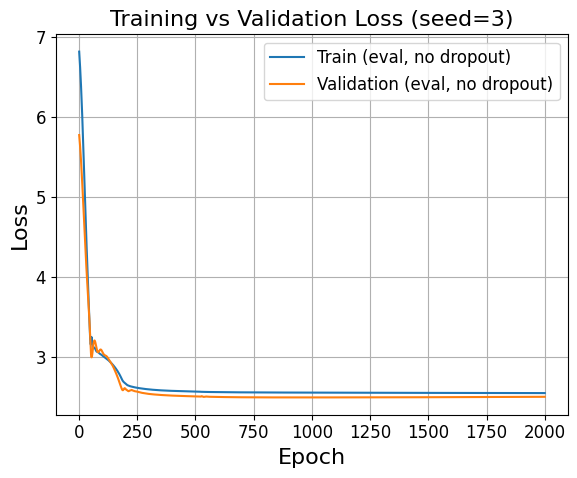

[Seed 3] cpu_time=319.848s, wall_time=311.515s, best_val=2.491549e+00 @ epoch 955

RUNNING SEED 4 (4/10)
[Init calib] step 0, loss=9.0699e-03
[Init calib] step 50, loss=3.1816e-04
[Init calib] step 100, loss=7.4688e-05
[Init calib] step 150, loss=2.4261e-05
[Init calib] step 200, loss=1.1745e-05
[Init calib] step 250, loss=7.3085e-06
[Init calib] step 300, loss=5.1435e-06
[Init calib] step 350, loss=3.4188e-06
[Init calib] step 400, loss=2.3797e-06
[Init calib] step 450, loss=1.6610e-06
[Init calib] step 500, loss=1.1730e-06
[Init calib] step 550, loss=8.3463e-07
[Init calib] step 600, loss=6.1846e-07
[Init calib] step 650, loss=4.4914e-07
[Init calib] step 700, loss=3.9094e-07
[Init calib] step 750, loss=3.0263e-07
[Init calib] step 800, loss=2.6249e-07
[Init calib] step 850, loss=2.3349e-07
[Init calib] step 900, loss=2.1087e-07
[Init calib] step 950, loss=1.7737e-07
[Seed 4 | Global] Epoch 50, train=3.711543, valid=3.651376
[Seed 4 | Global] Epoch 100, train=1.039238, valid=1.002246

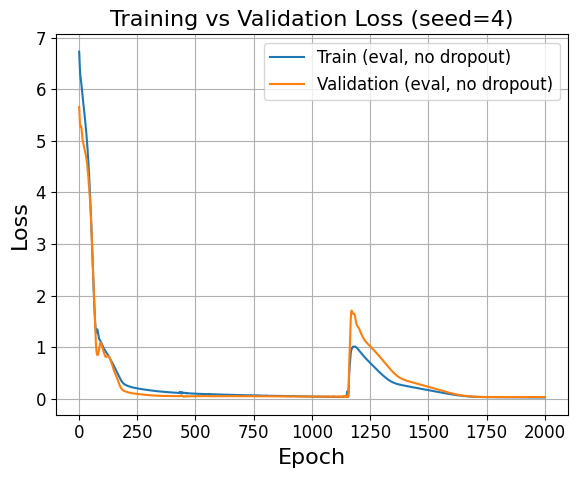

[Seed 4] cpu_time=316.982s, wall_time=339.783s, best_val=3.261652e-02 @ epoch 1969
--> NEW GLOBAL BEST: seed=4, best_val=3.261652e-02 at epoch 1969

RUNNING SEED 5 (5/10)
[Init calib] step 0, loss=1.6275e-02
[Init calib] step 50, loss=7.5117e-04
[Init calib] step 100, loss=1.7764e-04
[Init calib] step 150, loss=8.0634e-05
[Init calib] step 200, loss=3.5318e-05
[Init calib] step 250, loss=1.4578e-05
[Init calib] step 300, loss=6.3479e-06
[Init calib] step 350, loss=3.3582e-06
[Init calib] step 400, loss=2.2130e-06
[Init calib] step 450, loss=1.6855e-06
[Init calib] step 500, loss=1.3128e-06
[Init calib] step 550, loss=1.1131e-06
[Init calib] step 600, loss=9.5115e-07
[Init calib] step 650, loss=8.0394e-07
[Init calib] step 700, loss=6.7957e-07
[Init calib] step 750, loss=6.0349e-07
[Init calib] step 800, loss=5.0586e-07
[Init calib] step 850, loss=4.8178e-07
[Init calib] step 900, loss=4.0327e-07
[Init calib] step 950, loss=3.4592e-07
[Seed 5 | Global] Epoch 50, train=3.293682, valid=3.

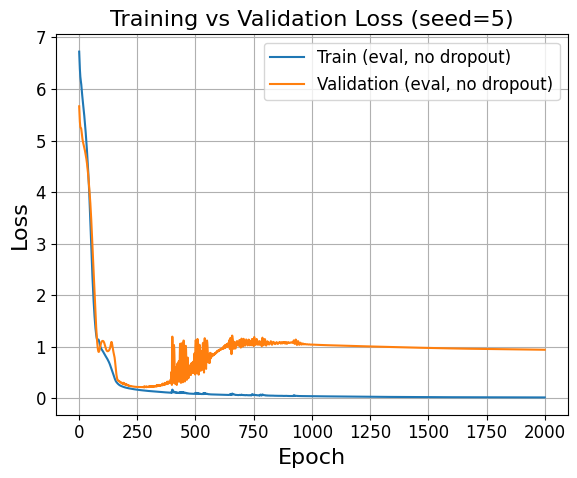

[Seed 5] cpu_time=319.888s, wall_time=346.443s, best_val=2.147581e-01 @ epoch 281

RUNNING SEED 6 (6/10)
[Init calib] step 0, loss=1.5455e-02
[Init calib] step 50, loss=5.1851e-04
[Init calib] step 100, loss=1.1434e-04
[Init calib] step 150, loss=4.9958e-05
[Init calib] step 200, loss=2.2551e-05
[Init calib] step 250, loss=1.0621e-05
[Init calib] step 300, loss=5.3232e-06
[Init calib] step 350, loss=2.9637e-06
[Init calib] step 400, loss=1.7177e-06
[Init calib] step 450, loss=1.0929e-06
[Init calib] step 500, loss=7.4899e-07
[Init calib] step 550, loss=5.2249e-07
[Init calib] step 600, loss=4.0296e-07
[Init calib] step 650, loss=2.9949e-07
[Init calib] step 700, loss=2.4557e-07
[Init calib] step 750, loss=2.1431e-07
[Init calib] step 800, loss=1.7275e-07
[Init calib] step 850, loss=1.3278e-07
[Init calib] step 900, loss=1.3386e-07
[Init calib] step 950, loss=1.0895e-07
[Seed 6 | Global] Epoch 50, train=4.292732, valid=4.124300
[Seed 6 | Global] Epoch 100, train=1.178435, valid=1.082855

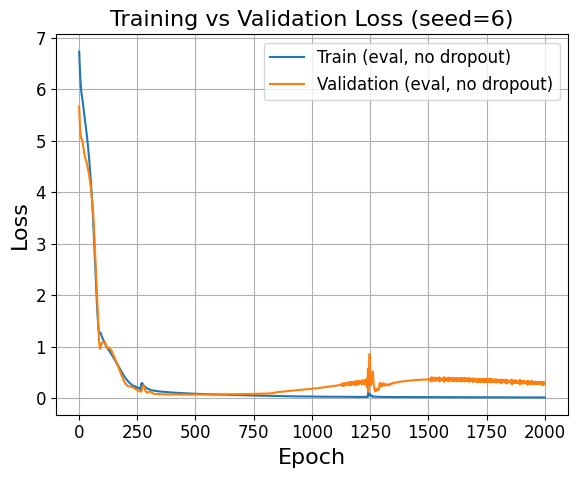

[Seed 6] cpu_time=317.330s, wall_time=332.337s, best_val=6.862815e-02 @ epoch 465

RUNNING SEED 7 (7/10)
[Init calib] step 0, loss=7.4174e-03
[Init calib] step 50, loss=9.1391e-05
[Init calib] step 100, loss=1.6683e-05
[Init calib] step 150, loss=4.8601e-06
[Init calib] step 200, loss=2.1050e-06
[Init calib] step 250, loss=1.3063e-06
[Init calib] step 300, loss=1.0229e-06
[Init calib] step 350, loss=8.5267e-07
[Init calib] step 400, loss=7.1250e-07
[Init calib] step 450, loss=6.2661e-07
[Init calib] step 500, loss=5.5123e-07
[Init calib] step 550, loss=5.0897e-07
[Init calib] step 600, loss=4.2507e-07
[Init calib] step 650, loss=3.9409e-07
[Init calib] step 700, loss=3.6445e-07
[Init calib] step 750, loss=3.3732e-07
[Init calib] step 800, loss=3.0473e-07
[Init calib] step 850, loss=2.7985e-07
[Init calib] step 900, loss=2.4923e-07
[Init calib] step 950, loss=2.8626e-07
[Seed 7 | Global] Epoch 50, train=3.203110, valid=3.095376
[Seed 7 | Global] Epoch 100, train=2.962980, valid=2.922096

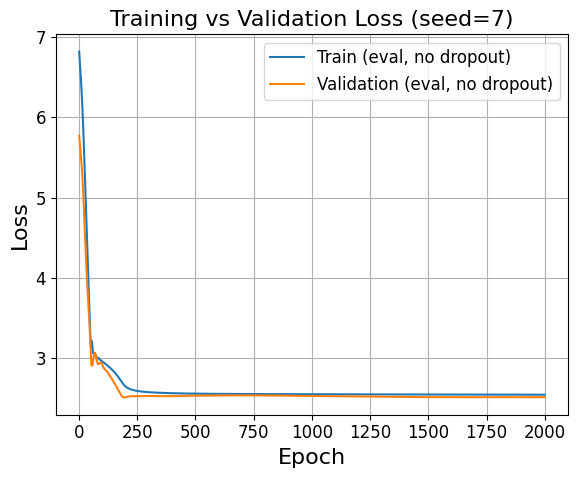

[Seed 7] cpu_time=318.321s, wall_time=306.729s, best_val=2.513168e+00 @ epoch 195

RUNNING SEED 8 (8/10)
[Init calib] step 0, loss=5.3862e-03
[Init calib] step 50, loss=2.1859e-04
[Init calib] step 100, loss=1.0847e-04
[Init calib] step 150, loss=5.3562e-05
[Init calib] step 200, loss=2.5169e-05
[Init calib] step 250, loss=1.1659e-05
[Init calib] step 300, loss=5.5903e-06
[Init calib] step 350, loss=2.8573e-06
[Init calib] step 400, loss=1.7036e-06
[Init calib] step 450, loss=1.1884e-06
[Init calib] step 500, loss=9.2878e-07
[Init calib] step 550, loss=7.8343e-07
[Init calib] step 600, loss=6.2750e-07
[Init calib] step 650, loss=5.4980e-07
[Init calib] step 700, loss=5.1166e-07
[Init calib] step 750, loss=4.0338e-07
[Init calib] step 800, loss=3.7027e-07
[Init calib] step 850, loss=3.2665e-07
[Init calib] step 900, loss=3.0318e-07
[Init calib] step 950, loss=2.7600e-07
[Seed 8 | Global] Epoch 50, train=4.303865, valid=4.147331
[Seed 8 | Global] Epoch 100, train=1.326679, valid=1.648754

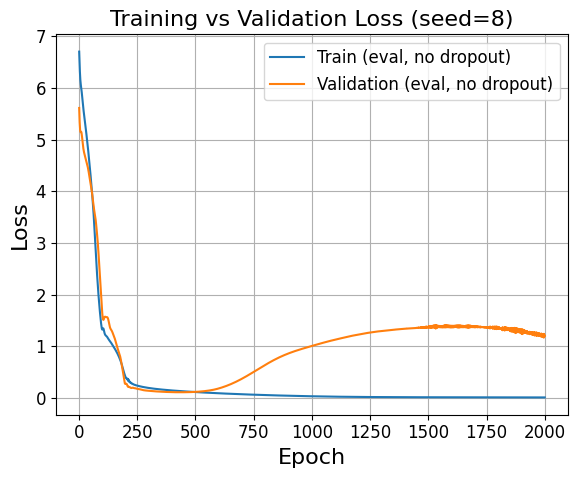

[Seed 8] cpu_time=321.377s, wall_time=346.536s, best_val=1.142977e-01 @ epoch 430

RUNNING SEED 9 (9/10)
[Init calib] step 0, loss=1.1382e-02
[Init calib] step 50, loss=1.6728e-04
[Init calib] step 100, loss=4.0367e-05
[Init calib] step 150, loss=2.3037e-05
[Init calib] step 200, loss=1.5050e-05
[Init calib] step 250, loss=1.0714e-05
[Init calib] step 300, loss=8.2104e-06
[Init calib] step 350, loss=6.5149e-06
[Init calib] step 400, loss=5.3544e-06
[Init calib] step 450, loss=4.5595e-06
[Init calib] step 500, loss=3.8624e-06
[Init calib] step 550, loss=3.3355e-06
[Init calib] step 600, loss=2.8528e-06
[Init calib] step 650, loss=2.4944e-06
[Init calib] step 700, loss=2.1348e-06
[Init calib] step 750, loss=1.8164e-06
[Init calib] step 800, loss=1.5905e-06
[Init calib] step 850, loss=1.3385e-06
[Init calib] step 900, loss=1.1541e-06
[Init calib] step 950, loss=9.9588e-07
[Seed 9 | Global] Epoch 50, train=4.041622, valid=3.982244
[Seed 9 | Global] Epoch 100, train=1.010490, valid=0.923327

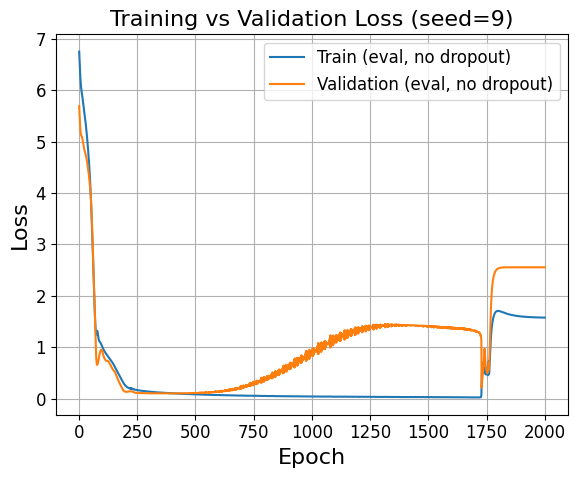

[Seed 9] cpu_time=322.274s, wall_time=340.435s, best_val=1.027111e-01 @ epoch 379

RUNNING SEED 10 (10/10)
[Init calib] step 0, loss=5.0295e-03
[Init calib] step 50, loss=1.0985e-04
[Init calib] step 100, loss=3.7872e-05
[Init calib] step 150, loss=1.2839e-05
[Init calib] step 200, loss=4.7607e-06
[Init calib] step 250, loss=2.1969e-06
[Init calib] step 300, loss=1.2685e-06
[Init calib] step 350, loss=7.9945e-07
[Init calib] step 400, loss=5.6767e-07
[Init calib] step 450, loss=3.9447e-07
[Init calib] step 500, loss=2.9885e-07
[Init calib] step 550, loss=2.3363e-07
[Init calib] step 600, loss=1.9136e-07
[Init calib] step 650, loss=1.5207e-07
[Init calib] step 700, loss=1.2878e-07
[Init calib] step 750, loss=9.7883e-08
[Init calib] step 800, loss=9.6132e-08
[Init calib] step 850, loss=7.7303e-08
[Init calib] step 900, loss=7.1286e-08
[Init calib] step 950, loss=6.2781e-08
[Seed 10 | Global] Epoch 50, train=4.867201, valid=4.528549
[Seed 10 | Global] Epoch 100, train=1.359183, valid=1.00

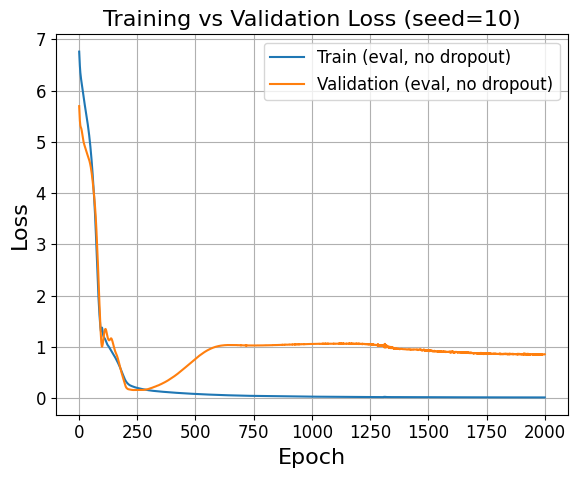

[Seed 10] cpu_time=321.989s, wall_time=352.827s, best_val=1.564295e-01 @ epoch 259

BEST-SEED SUMMARY (across seed sweep)
Training mode              : global
Seed sweep                 : 1..10  (N=10)
BEST seed                  : 4
BEST validation            : 3.261652e-02  (at epoch 1969)
Train loss @ best val      : 2.576309e-02
------------------------------------------------------------------------
Epochs                     : 2000
Optimizer                  : Adam
Learning rate (LR)         : 0.001
Hidden dropout (rate)      : 0.0
MLP architecture           : 3-5-4
# Total parameters         : 56  (includes net + IC offsets)
# Batches (train/valid)    : 3 / 1
------------------------------------------------------------------------
Final loss     (train)     : 2.542469e-02
Final loss     (valid)     : 3.347421e-02
------------------------------------------------------------------------
Learned vs. measured ICs (train) (first point):
  Batch 01: X0_learn=0.1841 (meas=0.1838, alpha_X

In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import config
from jax.experimental.ode import odeint
import optax
from jax.lib import xla_bridge

# ========================================================
# 1) (OPTIONAL) FORCE TPU FOR JAX (comment out if not on TPU)
# ========================================================
config.update("jax_platform_name", "tpu")
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"

# ========================================================
# 0. CONFIG: training mode + SEED sweep
# ========================================================
TRAIN_MODE = "global"         # "batch" or "global"
LR = 1e-3                     # Learning rate (Adam)
NUM_EPOCHS = 2000             # Number of epochs
DROPOUT_RATE_HIDDEN = 0.0     # Dropout in hidden layers (train only)
EPS = 1.0e-8                  # Avoid ~0 division in loss

SEED_START = 1                # base seed
N_SEEDS = 10                  # try seeds: SEED_START + 0..N_SEEDS-1

hidden_layers = [5]
layer_sizes = [3] + hidden_layers + [4]  # input=[X,G,A] -> output=[f1,f2,f3,g3]

LAMBDA_IC = 1e0

# Indexes
train_idxs = [0, 1, 3]
valid_idxs = [2]
test_idxs  = [4, 5, 6, 7, 8, 9]

# ========================================================
# 1. DATA PREP (raw_t, obs_X, obs_G, obs_A must already exist)
# ========================================================
t_batches = [jax.device_put(jnp.array(arr)) for arr in raw_t]
X_batches = [jax.device_put(jnp.array(arr)) for arr in obs_X]
G_batches = [jax.device_put(jnp.array(arr)) for arr in obs_G]
A_batches = [jax.device_put(jnp.array(arr)) for arr in obs_A]

t_train = [t_batches[i] for i in train_idxs]
X_train = [X_batches[i] for i in train_idxs]
G_train = [G_batches[i] for i in train_idxs]
A_train = [A_batches[i] for i in train_idxs]

t_valid = [t_batches[i] for i in valid_idxs]
X_valid = [X_batches[i] for i in valid_idxs]
G_valid = [G_batches[i] for i in valid_idxs]
A_valid = [A_batches[i] for i in valid_idxs]

t_test = [t_batches[i] for i in test_idxs]
X_test = [X_batches[i] for i in test_idxs]
G_test = [G_batches[i] for i in test_idxs]
A_test = [A_batches[i] for i in test_idxs]

# ========================================================
# 1.1 Helpers
# ========================================================
def count_params_pytree(pytree):
    leaves, _ = jax.tree_util.tree_flatten(pytree)
    total = 0
    for l in leaves:
        if isinstance(l, (np.ndarray, jnp.ndarray)):
            total += int(np.prod(np.array(l.shape)))
        else:
            total += 1
    return total

def arch_string(layer_sizes):
    return "-".join(str(n) for n in layer_sizes)

def pytree_snapshot_to_cpu(pytree):
    """Safe snapshot of params: convert to numpy arrays on host."""
    return jax.tree_util.tree_map(lambda x: np.array(x), pytree)

def ensure_dir(path):
    os.makedirs(path, exist_ok=True)

# ========================================================
# 2. NEURAL NETWORK + HYBRID ODE
# ========================================================
def init_net_params(rng_key, layer_sizes):
    params = {}
    keys = jax.random.split(rng_key, 2 * (len(layer_sizes) - 1))
    k = 0
    for i in range(len(layer_sizes) - 1):
        n_in, n_out = layer_sizes[i], layer_sizes[i + 1]
        params[f"W{i}"] = jax.random.uniform(keys[k], (n_out, n_in), minval=-0.1, maxval=0.1)
        params[f"b{i}"] = jax.random.uniform(keys[k + 1], (n_out,), minval=-0.1, maxval=0.1)
        k += 2
    return params

def sample_hidden_masks(net_params, rate, rng):
    if rate is None or rate <= 0.0:
        return None
    keep = 1.0 - rate
    masks = []
    num_layers = len(net_params) // 2
    for i in range(num_layers - 1):
        size = net_params[f"b{i}"].shape
        rng, ki = jax.random.split(rng)
        mask = jax.random.bernoulli(ki, p=keep, shape=size)
        mask = mask.astype(jnp.float32) / keep
        masks.append(mask)
    return masks

def neural_network(net_params, y, *, train: bool = False, masks=None):
    a = y
    num_layers = len(net_params) // 2
    for i in range(num_layers):
        W, b = net_params[f"W{i}"], net_params[f"b{i}"]
        z = W @ a + b
        if i < num_layers - 1:
            a = jnp.tanh(z)
            if train and (masks is not None):
                a = a * masks[i]
        else:
            a = z
    return a

def model_jax(net_params, y, t, *, train=False, masks=None):
    X, G, A = y
    f1, f2, f3, g3 = neural_network(net_params, jnp.array([X, G, A]), train=train, masks=masks)
    g3_clamped = jax.nn.relu(g3)
    return jnp.stack([f1 * X, f2 * G * X, f3 * A * X + g3_clamped * X])

def predict(net_params, t_array, X0, G0, *, A0=0.0, train=False, masks=None):
    def rhs(y, tt):
        return model_jax(net_params, y, tt, train=train, masks=masks)
    y0 = jnp.array([X0, G0, A0])
    sol = odeint(rhs, y0, t_array, mxstep=2000)
    return sol[:, 0], sol[:, 1], sol[:, 2]

predict = jax.jit(predict, static_argnames=("train",))

# ========================================================
# 2.1 IC via LOG-OFFSETS
# ========================================================
def init_ic_offset_params_from_data(X_train, G_train):
    n = len(X_train)
    X0_meas = jnp.array([float(np.array(X_train[i])[0]) for i in range(n)])
    G0_meas = jnp.array([float(np.array(G_train[i])[0]) for i in range(n)])
    ic_alpha = {"alpha_X": jnp.zeros_like(X0_meas), "alpha_G": jnp.zeros_like(G0_meas)}
    ic_meas  = {"X0": X0_meas, "G0": G0_meas}
    return ic_alpha, ic_meas

def ic_for_train_batch(params, idx):
    X0_meas = params["ic_meas"]["X0"][idx]
    G0_meas = params["ic_meas"]["G0"][idx]
    alpha_X = params["ic_alpha"]["alpha_X"][idx]
    alpha_G = params["ic_alpha"]["alpha_G"][idx]
    X0 = X0_meas * jnp.exp(alpha_X)
    G0 = G0_meas * jnp.exp(alpha_G)
    A0 = jnp.array(0.0)
    return X0, G0, A0

# ========================================================
# 3. LOSSES
# ========================================================
def safe_rel(pred, obs):
    denom = jnp.maximum(jnp.mean(jnp.abs(obs)), EPS)
    return (pred - obs) / denom

def ic_reg_term(params, idx, lambda_ic=LAMBDA_IC):
    alpha_X = params["ic_alpha"]["alpha_X"][idx]
    alpha_G = params["ic_alpha"]["alpha_G"][idx]
    return lambda_ic * (alpha_X**2 + alpha_G**2)

def batch_loss_train(params, idx, rng):
    net_params = params["net"]
    t_obs, X_obs, G_obs, A_obs = (t_train[idx], X_train[idx], G_train[idx], A_train[idx])
    X0, G0, A0 = ic_for_train_batch(params, idx)

    masks = sample_hidden_masks(net_params, DROPOUT_RATE_HIDDEN, rng)

    X_pred, G_pred, A_pred = predict(net_params, t_obs, X0, G0, A0=A0, train=True, masks=masks)
    rX = safe_rel(X_pred, X_obs); rG = safe_rel(G_pred, G_obs); rA = safe_rel(A_pred, A_obs)
    data_loss = jnp.mean(rX**2) + jnp.mean(rG**2) + jnp.mean(rA**2)

    reg_loss = ic_reg_term(params, idx, LAMBDA_IC)
    return data_loss + reg_loss

batch_loss_train_jit = jax.jit(batch_loss_train, static_argnums=(1,))

def global_train_loss(params, rng_key):
    total = 0.0
    for idx in range(len(t_train)):
        sk = jax.random.fold_in(rng_key, idx)
        total += batch_loss_train(params, idx, sk)
    return total / len(t_train)

def batch_loss_train_eval(params, idx):
    net_params = params["net"]
    t_obs, X_obs, G_obs, A_obs = (t_train[idx], X_train[idx], G_train[idx], A_train[idx])
    X0, G0, A0 = ic_for_train_batch(params, idx)
    X_pred, G_pred, A_pred = predict(net_params, t_obs, X0, G0, A0=A0, train=False, masks=None)
    rX = safe_rel(X_pred, X_obs); rG = safe_rel(G_pred, G_obs); rA = safe_rel(A_pred, A_obs)
    return jnp.mean(rX**2) + jnp.mean(rG**2) + jnp.mean(rA**2)

batch_loss_train_eval = jax.jit(batch_loss_train_eval, static_argnums=(1,))

def batch_loss_valid_eval(params, idx):
    net_params = params["net"]
    t_obs, X_obs, G_obs, A_obs = (t_valid[idx], X_valid[idx], G_valid[idx], A_valid[idx])
    X0, G0 = X_obs[0], G_obs[0]
    A0 = jnp.array(0.0)
    X_pred, G_pred, A_pred = predict(net_params, t_obs, X0, G0, A0=A0, train=False, masks=None)
    rX = safe_rel(X_pred, X_obs); rG = safe_rel(G_pred, G_obs); rA = safe_rel(A_pred, A_obs)
    return jnp.mean(rX**2) + jnp.mean(rG**2) + jnp.mean(rA**2)

batch_loss_valid_eval = jax.jit(batch_loss_valid_eval, static_argnums=(1,))

def eval_avg_train_loss(params):
    vals = [float(batch_loss_train_eval(params, i)) for i in range(len(t_train))]
    return np.mean(vals) if vals else np.nan

def eval_avg_valid_loss(params):
    vals = [float(batch_loss_valid_eval(params, i)) for i in range(len(t_valid))]
    return np.mean(vals) if vals else np.nan

# ========================================================
# 4. ZERO-FIELD PRETRAINING
# ========================================================
TARGET_F = 0.0
TARGET_G = 0.0
target_vec = jnp.array([TARGET_F, TARGET_F, TARGET_F, TARGET_G])

def calib_loss(net_params, points):
    def per_point(y):
        out = neural_network(net_params, y, train=False)
        return jnp.mean((out - target_vec) ** 2)
    return jnp.mean(jax.vmap(per_point)(points))

def calibrate_with_data(net_params, points, steps=1000, lr=1e-3):
    optc = optax.adam(lr)
    opt_state = optc.init(net_params)

    @jax.jit
    def step(p, s):
        loss, grads = jax.value_and_grad(calib_loss)(p, points)
        updates, s = optc.update(grads, s, p)
        p = optax.apply_updates(p, updates)
        return p, s, loss

    p = net_params
    for i in range(steps):
        p, opt_state, loss = step(p, opt_state)
        if i % 50 == 0:
            print(f"[Init calib] step {i}, loss={loss:.4e}")
    return p

# ========================================================
# 5. PLOTTING PER SEED (during sweep)
# ========================================================
def plot_losses_for_seed(seed, train_hist, valid_hist, outdir=None):
    plt.figure(figsize=(6, 5))
    epochs = np.arange(1, len(train_hist) + 1)
    plt.plot(epochs, train_hist, label="Train (eval, no dropout)")
    plt.plot(epochs, valid_hist, label="Validation (eval, no dropout)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training vs Validation Loss (seed={seed})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if outdir is not None:
        ensure_dir(outdir)
        plt.savefig(os.path.join(outdir, f"loss_seed_{seed}.png"), dpi=200)
    plt.show()

# ========================================================
# 6. ONE-RUN TRAINING FUNCTION (one seed)
#     -> returns best epoch/val/params + histories + timing
# ========================================================
def run_one_seed(seed: int, plot_each_seed: bool = True, plot_dir: str = "seed_plots"):
    # Seed PRNGs
    rng_master = jax.random.PRNGKey(seed)
    np.random.seed(seed)

    # --- start per-seed timers ---
    t0_cpu  = time.process_time()
    t0_wall = time.perf_counter()

    # Init net params
    rng_params = jax.random.fold_in(rng_master, 0)
    net_params = init_net_params(rng_params, layer_sizes)

    # Calibration points from TRAIN data
    calib_points = []
    for Xb, Gb, Ab in zip(X_train, G_train, A_train):
        for X0, G0, A0 in zip(np.array(Xb), np.array(Gb), np.array(Ab)):
            calib_points.append([X0, G0, A0])
    calib_points_jnp = jnp.array(calib_points)

    # Zero-field pretraining
    net_params = calibrate_with_data(net_params, calib_points_jnp, steps=1000, lr=1e-3)

    # IC offsets
    ic_alpha, ic_meas = init_ic_offset_params_from_data(X_train, G_train)
    params = {"net": net_params, "ic_alpha": ic_alpha, "ic_meas": ic_meas}

    # Optimizer
    opt = optax.adam(LR)
    opt_state = opt.init(params)

    train_history, valid_history = [], []
    best_val = np.inf
    best_epoch = None
    best_params = None

    if TRAIN_MODE == "batch":
        def train_step(params, opt_state, idx, rng):
            grads = jax.grad(batch_loss_train_jit)(params, idx, rng)
            updates, opt_state = opt.update(grads, opt_state, params)
            return optax.apply_updates(params, updates), opt_state

        train_step = jax.jit(train_step, static_argnums=(2,))

        for epoch in range(1, NUM_EPOCHS + 1):
            epoch_key = jax.random.fold_in(rng_master, epoch)
            perm = np.array(jax.random.permutation(epoch_key, len(t_train)))

            for idx in perm:
                batch_key = jax.random.fold_in(epoch_key, int(idx))
                params, opt_state = train_step(params, opt_state, int(idx), batch_key)

            tr_loss = eval_avg_train_loss(params)
            va_loss = eval_avg_valid_loss(params)
            train_history.append(tr_loss)
            valid_history.append(va_loss)

            if va_loss < best_val:
                best_val = float(va_loss)
                best_epoch = epoch
                best_params = pytree_snapshot_to_cpu(params)

            if epoch % 50 == 0:
                print(f"[Seed {seed} | Batch] Epoch {epoch}, train={tr_loss:.6f}, valid={va_loss:.6f}")

    elif TRAIN_MODE == "global":
        for epoch in range(1, NUM_EPOCHS + 1):
            epoch_key = jax.random.fold_in(rng_master, epoch)
            grads = jax.grad(global_train_loss)(params, epoch_key)
            updates, opt_state = opt.update(grads, opt_state, params)
            params = optax.apply_updates(params, updates)

            tr_loss = eval_avg_train_loss(params)
            va_loss = eval_avg_valid_loss(params)
            train_history.append(tr_loss)
            valid_history.append(va_loss)

            if va_loss < best_val:
                best_val = float(va_loss)
                best_epoch = epoch
                best_params = pytree_snapshot_to_cpu(params)

            if epoch % 50 == 0:
                print(f"[Seed {seed} | Global] Epoch {epoch}, train={tr_loss:.6f}, valid={va_loss:.6f}")

    else:
        raise ValueError("TRAIN_MODE must be 'batch' or 'global'")

    # --- stop per-seed timers ---
    cpu_time_s  = time.process_time() - t0_cpu
    wall_time_s = time.perf_counter() - t0_wall

    train_history = np.array(train_history, dtype=float)
    valid_history = np.array(valid_history, dtype=float)

    # Plot per seed (as it iterates)
    if plot_each_seed:
        plot_losses_for_seed(seed, train_history, valid_history, outdir=plot_dir)

    return {
        "seed": seed,
        "best_val": best_val,
        "best_epoch": best_epoch,
        "best_params": best_params,            # CPU snapshot
        "train_history": train_history,
        "valid_history": valid_history,
        "cpu_time_s": float(cpu_time_s),
        "wall_time_s": float(wall_time_s),
    }

# ========================================================
# 7. SWEEP SEEDS (keep best seed/epoch overall)
# ========================================================
all_runs = []

global_best = {
    "seed": None,
    "best_val": np.inf,
    "best_epoch": None,
    "best_params": None,
    "train_history": None,
    "valid_history": None,
    "cpu_time_s": None,
    "wall_time_s": None,
}

for k in range(N_SEEDS):
    seed = SEED_START + k
    print("\n" + "="*80)
    print(f"RUNNING SEED {seed} ({k+1}/{N_SEEDS})")
    print("="*80)

    run = run_one_seed(seed, plot_each_seed=True, plot_dir="seed_plots")
    all_runs.append(run)

    print(f"[Seed {seed}] cpu_time={run['cpu_time_s']:.3f}s, wall_time={run['wall_time_s']:.3f}s, "
          f"best_val={run['best_val']:.6e} @ epoch {run['best_epoch']}")

    if run["best_val"] < global_best["best_val"]:
        global_best = run
        print(f"--> NEW GLOBAL BEST: seed={seed}, best_val={run['best_val']:.6e} at epoch {run['best_epoch']}")

# ========================================================
# 8. PRINT SUMMARY FOR THE BEST SEED
# ========================================================
best_seed = global_best["seed"]
best_epoch = global_best["best_epoch"]
best_val = global_best["best_val"]
best_params = global_best["best_params"]

# Reconstruct learned ICs (train) from best_params
alpha_X_learn = np.array(best_params["ic_alpha"]["alpha_X"])
alpha_G_learn = np.array(best_params["ic_alpha"]["alpha_G"])
X0_meas_np = np.array(best_params["ic_meas"]["X0"])
G0_meas_np = np.array(best_params["ic_meas"]["G0"])
X0_learn = X0_meas_np * np.exp(alpha_X_learn)
G0_learn = G0_meas_np * np.exp(alpha_G_learn)

best_train_history = global_best["train_history"]
best_valid_history = global_best["valid_history"]

best_train_at_best_epoch = float(best_train_history[best_epoch - 1]) if best_epoch is not None else float("nan")
final_train = float(best_train_history[-1]) if best_train_history is not None else float("nan")
final_val   = float(best_valid_history[-1]) if best_valid_history is not None else float("nan")

n_params_total = count_params_pytree(best_params)
n_train_batches = len(t_train)
n_valid_batches = len(t_valid)

devices = jax.devices()
platform = xla_bridge.get_backend().platform if hasattr(xla_bridge, "get_backend") else "unknown"
device_names = ", ".join(getattr(d, "device_kind", str(d)) for d in devices)

print("\n" + "="*72)
print("BEST-SEED SUMMARY (across seed sweep)")
print("="*72)
print(f"Training mode              : {TRAIN_MODE}")
print(f"Seed sweep                 : {SEED_START}..{SEED_START + N_SEEDS - 1}  (N={N_SEEDS})")
print(f"BEST seed                  : {best_seed}")
print(f"BEST validation            : {best_val:.6e}  (at epoch {best_epoch})")
print(f"Train loss @ best val      : {best_train_at_best_epoch:.6e}")
print("-"*72)
print(f"Epochs                     : {NUM_EPOCHS}")
print(f"Optimizer                  : Adam")
print(f"Learning rate (LR)         : {LR:g}")
print(f"Hidden dropout (rate)      : {DROPOUT_RATE_HIDDEN}")
print(f"MLP architecture           : {arch_string(layer_sizes)}")
print(f"# Total parameters         : {n_params_total:,}  (includes net + IC offsets)")
print(f"# Batches (train/valid)    : {n_train_batches} / {n_valid_batches}")
print("-"*72)
print(f"Final loss     (train)     : {final_train:.6e}")
print(f"Final loss     (valid)     : {final_val:.6e}")
print("-"*72)
print("Learned vs. measured ICs (train) (first point):")
for i in range(n_train_batches):
    print(
        f"  Batch {i+1:02d}: "
        f"X0_learn={X0_learn[i]:.4f} (meas={X0_meas_np[i]:.4f}, alpha_X={alpha_X_learn[i]:+.3f}), "
        f"G0_learn={G0_learn[i]:.4f} (meas={G0_meas_np[i]:.4f}, alpha_G={alpha_G_learn[i]:+.3f}), "
        f"A0_fixed=0.0000"
    )
print("-"*72)
print(f"Best-seed CPU time (s)     : {global_best['cpu_time_s']:.3f}")
print(f"Best-seed Wall time (s)    : {global_best['wall_time_s']:.3f}")
print("-"*72)
print(f"JAX platform / devices     : {platform} / {device_names}")
print("="*72 + "\n")

# ========================================================
# 9. OPTIONAL: SEED LEADERBOARD (includes timing)
# ========================================================
print("SEED LEADERBOARD (best validation per seed):")
for run in sorted(all_runs, key=lambda r: r["best_val"]):
    print(f"  seed={run['seed']}  best_val={run['best_val']:.6e}  best_epoch={run['best_epoch']}  "
          f"cpu={run['cpu_time_s']:.2f}s  wall={run['wall_time_s']:.2f}s")


### Plot description

This code defines the function `plot_selected_batches`, which compares the experimental batch data with the predictions of the trained hybrid model for any chosen set of batch indices.

For each selected batch:

* A dense time grid is constructed to generate smooth model trajectories.
* Initial conditions depend on the batch type:
  * If the batch index belongs to the training set, the function uses the **learned initial conditions** obtained through the log-offset parameters.
  * Otherwise (validation or test), the function uses the **measured initial conditions** from the first data point.
* In all cases, the acetate initial value is fixed at $A_{0} = 0$.
* The model trajectories are computed using `predict` and plotted together with the corresponding experimental data.
* Common y-limits are automatically computed (unless provided by the user) so that all subplots share consistent vertical scales for:
  * $X$ and $G$ on the left axis,
  * $A$ on the right axis.

In each subplot:

* $X$ (biomass) is plotted in blue.
* $G$ (glucose) is plotted in green.
* $A$ (acetate) is plotted in red.
* The title includes the batch index and the initial glucose value $G_{0}$ taken from the data.

The selected batches are arranged in a user-defined grid (specified by `grid = (rows, cols)`), and any unused subplot panels are automatically hidden. The function returns a single matplotlib figure, which can be saved in SVG format and downloaded in Colab for high-quality output.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

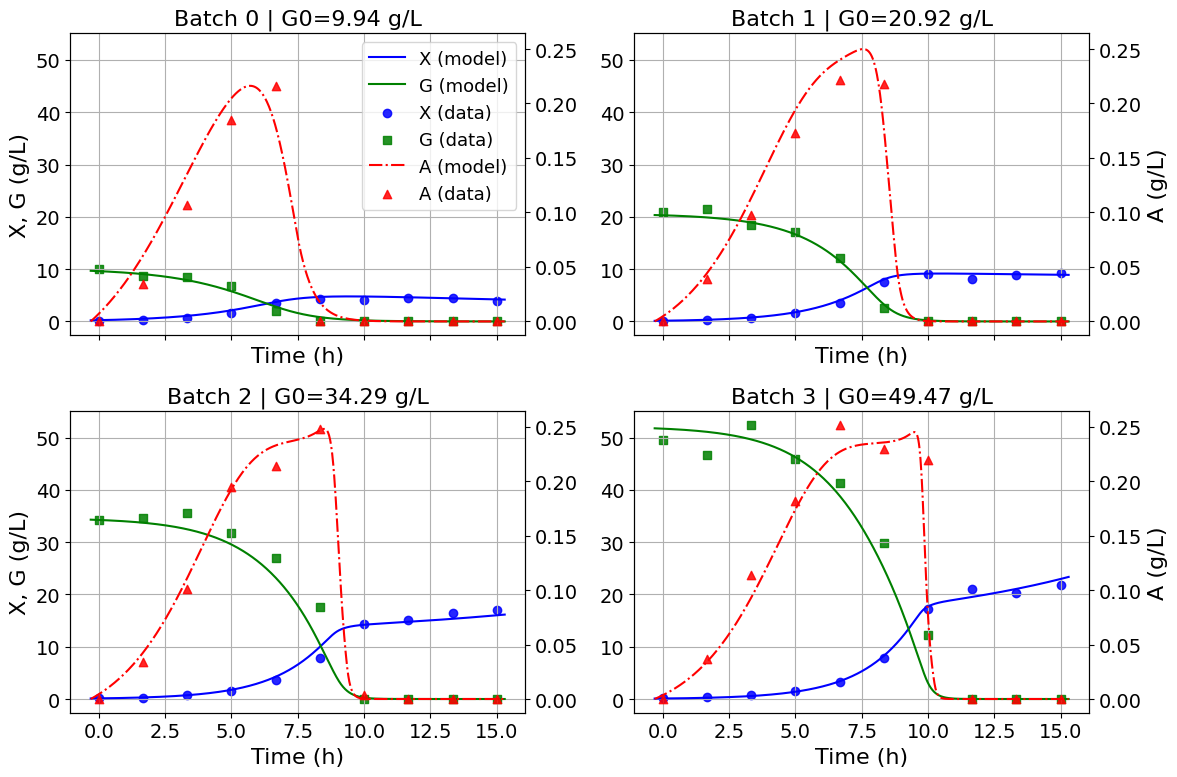

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

# ====== Larger fonts (global) ======
plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 13,
    "figure.titlesize": 18
})

def plot_selected_batches(
    params_for_plot,
    plt_idxs,
    *,
    grid=(2, 2),
    n_time_plot=800,
    pad_frac=0.02,
    y_XG_limits=None,
    y_A_limits=None
):
    """
    Plot simulations and data for a selected set of batch indices.

    Parameters
    ----------
    params_for_plot : dict
        Parameter pytree, must contain at least params_for_plot["net"]
        for the neural network used in `predict`, and IC info for training
        batches (params_for_plot["ic_alpha"], params_for_plot["ic_meas"]).
    plt_idxs : list of int
        Indices of the batches (in the original arrays raw_t, obs_X, obs_G, obs_A)
        to be plotted.
    grid : tuple (rows, cols), optional
        Layout of subplots.
    n_time_plot : int, optional
        Number of points in the dense time grid for the model curves.
    pad_frac : float, optional
        Extra padding fraction for time axis when building dense grid.
    y_XG_limits : tuple or None, optional
        (ymin, ymax) for X and G axes. If None, computed from data+model.
    y_A_limits : tuple or None, optional
        (ymin, ymax) for A axis. If None, computed from data+model.

    Notes
    -----
    * For batches whose index is in `train_idxs`, the function uses the
      learned initial conditions via `ic_for_train_batch`.
    * For all other batches (validation and test), the function uses the
      measured initial conditions from the first observation, with A0 = 0.
    Expects the following globals to exist:
      - t_batches, X_batches, G_batches, A_batches
      - train_idxs
      - predict (JAX-ODE forward)
      - ic_for_train_batch(params, train_pos)
    """
    # ---------- Helper functions ----------
    def _dense_time_grid(t_batch_np, n_time_plot=800, pad_frac=0.02):
        t0 = float(np.min(t_batch_np))
        t1 = float(np.max(t_batch_np))
        if t1 <= t0:
            t1 = t0 + 1e-6
        span = t1 - t0
        t0p = t0 - pad_frac * span
        t1p = t1 + pad_frac * span
        return jnp.linspace(t0p, t1p, n_time_plot)

    def _measured_ic_for_batch(X_obs_np, G_obs_np):
        """
        Use measured initial values from the first observation.
        A0 is fixed to 0.0.
        """
        X0 = float(X_obs_np[0])
        G0 = float(G_obs_np[0])
        A0 = 0.0
        return X0, G0, A0

    def _maybe_G0_from_array(G_obs_np):
        """Get G0 directly from data (first value)."""
        if len(G_obs_np) == 0:
            return None
        return float(G_obs_np[0])

    def _with_pad(vmin, vmax, frac=0.05):
        span = vmax - vmin
        if span == 0:
            base = max(abs(vmin), abs(vmax), 1.0)
            return vmin - base*frac, vmax + base*frac
        pad = span * frac
        return vmin - pad, vmax + pad

    # Map from original batch index -> position in train arrays
    # (ic_for_train_batch expects indices in [0, len(t_train)-1])
    train_pos_by_orig = {orig_idx: pos for pos, orig_idx in enumerate(train_idxs)}

    def _initial_conditions_for_batch(params_local, batch_idx, X_obs_np, G_obs_np):
        """
        If batch_idx is a training batch, use learned ICs via ic_for_train_batch.
        Otherwise, use measured ICs from data.
        """
        if batch_idx in train_pos_by_orig:
            train_pos = train_pos_by_orig[batch_idx]
            X0_jax, G0_jax, A0_jax = ic_for_train_batch(params_local, train_pos)
            X0 = float(X0_jax)
            G0 = float(G0_jax)
            A0 = float(A0_jax)
            return X0, G0, A0
        else:
            # validation or test: measured ICs
            return _measured_ic_for_batch(X_obs_np, G_obs_np)

    # ---------- Build local splits from plt_idxs ----------
    t_split = [t_batches[i] for i in plt_idxs]
    X_split = [X_batches[i] for i in plt_idxs]
    G_split = [G_batches[i] for i in plt_idxs]
    A_split = [A_batches[i] for i in plt_idxs]

    n_batches = len(t_split)
    rows, cols = grid
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows), sharex=True)
    axes = np.array(axes).reshape(rows, cols).flatten()

    net_params = params_for_plot["net"]

    # --- First pass: predictions + global limits ---
    cache = []
    XG_vals, A_vals = [], []

    for k in range(n_batches):
        t_i, X_i, G_i, A_i = t_split[k], X_split[k], G_split[k], A_split[k]
        t_obs_np = np.array(t_i)
        X_obs_np = np.array(X_i)
        G_obs_np = np.array(G_i)
        A_obs_np = np.array(A_i)

        # Dense time grid
        t_dense = _dense_time_grid(t_obs_np, n_time_plot=n_time_plot, pad_frac=pad_frac)

        # Initial conditions: learned for training batches, measured otherwise
        batch_idx = plt_idxs[k]
        X0_i, G0_i, A0_i = _initial_conditions_for_batch(
            params_for_plot, batch_idx, X_obs_np, G_obs_np
        )

        # Predict
        X_pred_d, G_pred_d, A_pred_d = predict(
            net_params, t_dense, X0_i, G0_i, A0=A0_i, train=False, masks=None
        )

        entry = {
            "t_obs": t_obs_np,
            "t_dense": np.array(t_dense),
            "X_obs": X_obs_np, "G_obs": G_obs_np, "A_obs": A_obs_np,
            "X_pred": np.array(X_pred_d), "G_pred": np.array(G_pred_d), "A_pred": np.array(A_pred_d),
            "batch_idx": batch_idx,
            "X0": X0_i, "G0": G0_i, "A0": A0_i
        }
        cache.append(entry)

        XG_vals.extend([X_obs_np, G_obs_np, entry["X_pred"], entry["G_pred"]])
        A_vals.extend([A_obs_np, entry["A_pred"]])

    # Compute global y-limits if not provided
    if y_XG_limits is None:
        XG_lo, XG_hi = _with_pad(
            min(np.min(v) for v in XG_vals),
            max(np.max(v) for v in XG_vals)
        )
    else:
        XG_lo, XG_hi = y_XG_limits

    if y_A_limits is None:
        A_lo, A_hi = _with_pad(
            min(np.min(v) for v in A_vals),
            max(np.max(v) for v in A_vals)
        )
    else:
        A_lo, A_hi = y_A_limits

    # --- Second pass: plotting ---
    for i, entry in enumerate(cache):
        if i >= rows * cols:
            break
        ax1 = axes[i]
        ax2 = ax1.twinx()
        ax1.set_ylim(XG_lo, XG_hi)
        ax2.set_ylim(A_lo, A_hi)

        # Model curves
        ax1.plot(entry["t_dense"], entry["X_pred"], '-',  color='b', label='X (model)')
        ax1.plot(entry["t_dense"], entry["G_pred"], '-',  color='g', label='G (model)')
        ax2.plot(entry["t_dense"], entry["A_pred"], '-.', color='r', label='A (model)')

        # Data
        ax1.scatter(entry["t_obs"], entry["X_obs"], marker='o', color='b', alpha=0.85, label='X (data)')
        ax1.scatter(entry["t_obs"], entry["G_obs"], marker='s', color='g', alpha=0.85, label='G (data)')
        ax2.scatter(entry["t_obs"], entry["A_obs"], marker='^', color='r', alpha=0.85, label='A (data)')

        # Title: use batch index and G0 from data
        G0_val = _maybe_G0_from_array(entry["G_obs"])
        if G0_val is not None:
            ax1.set_title(f"Batch {entry['batch_idx']} | G0={G0_val:.2f} g/L")
        else:
            ax1.set_title(f"Batch {entry['batch_idx']}")

        # Labels
        if i % cols == 0:
            ax1.set_ylabel("X, G (g/L)")
        if (i % cols == cols - 1) or (i == len(cache) - 1):
            ax2.set_ylabel("A (g/L)")
        ax1.set_xlabel("Time (h)")
        ax1.grid(True)

        # Legend once
        if i == 0:
            l1, lb1 = ax1.get_legend_handles_labels()
            l2, lb2 = ax2.get_legend_handles_labels()
            ax1.legend(l1 + l2, lb1 + lb2, loc="upper right")

    # Hide unused subplots
    for j in range(len(cache), rows * cols):
        axes[j].axis('off')

    fig.tight_layout()
    return fig


fname = "batches_1357.svg"

fig = plot_selected_batches(best_params, plt_idxs=[0,1,2,3], grid=(2,2))
fig.savefig(fname, format="svg", dpi=300)

from google.colab import files
files.download(fname)

### Description of the network output plots

This code visualizes the **outputs of the neural network** trained within the hybrid model framework.  
It helps inspect how the learned functions behave with respect to the state variables **X**, **G**, and **A**.

Only **data points for which we have experimental observations** are plotted — ensuring that the analysis reflects the actual range of measured conditions.

- **Figure 1** shows a 4×3 grid:
  - Each row corresponds to one network output: \(f_1, f_2, f_3,\) and \(g_3)\).
  - Each column corresponds to one input variable: \(X\), \(G\), and \(A\).
  - This allows visual inspection of how each learned function varies with the inputs.

- **Figure 2** displays \(g_3\) versus \(f_1\), highlighting how the non-negative output \(g_3\) relates to the inferred specific growth rate function \(f_1\).

These plots provide a compact way to verify that the neural network captures biologically meaningful relationships within the observed data range.


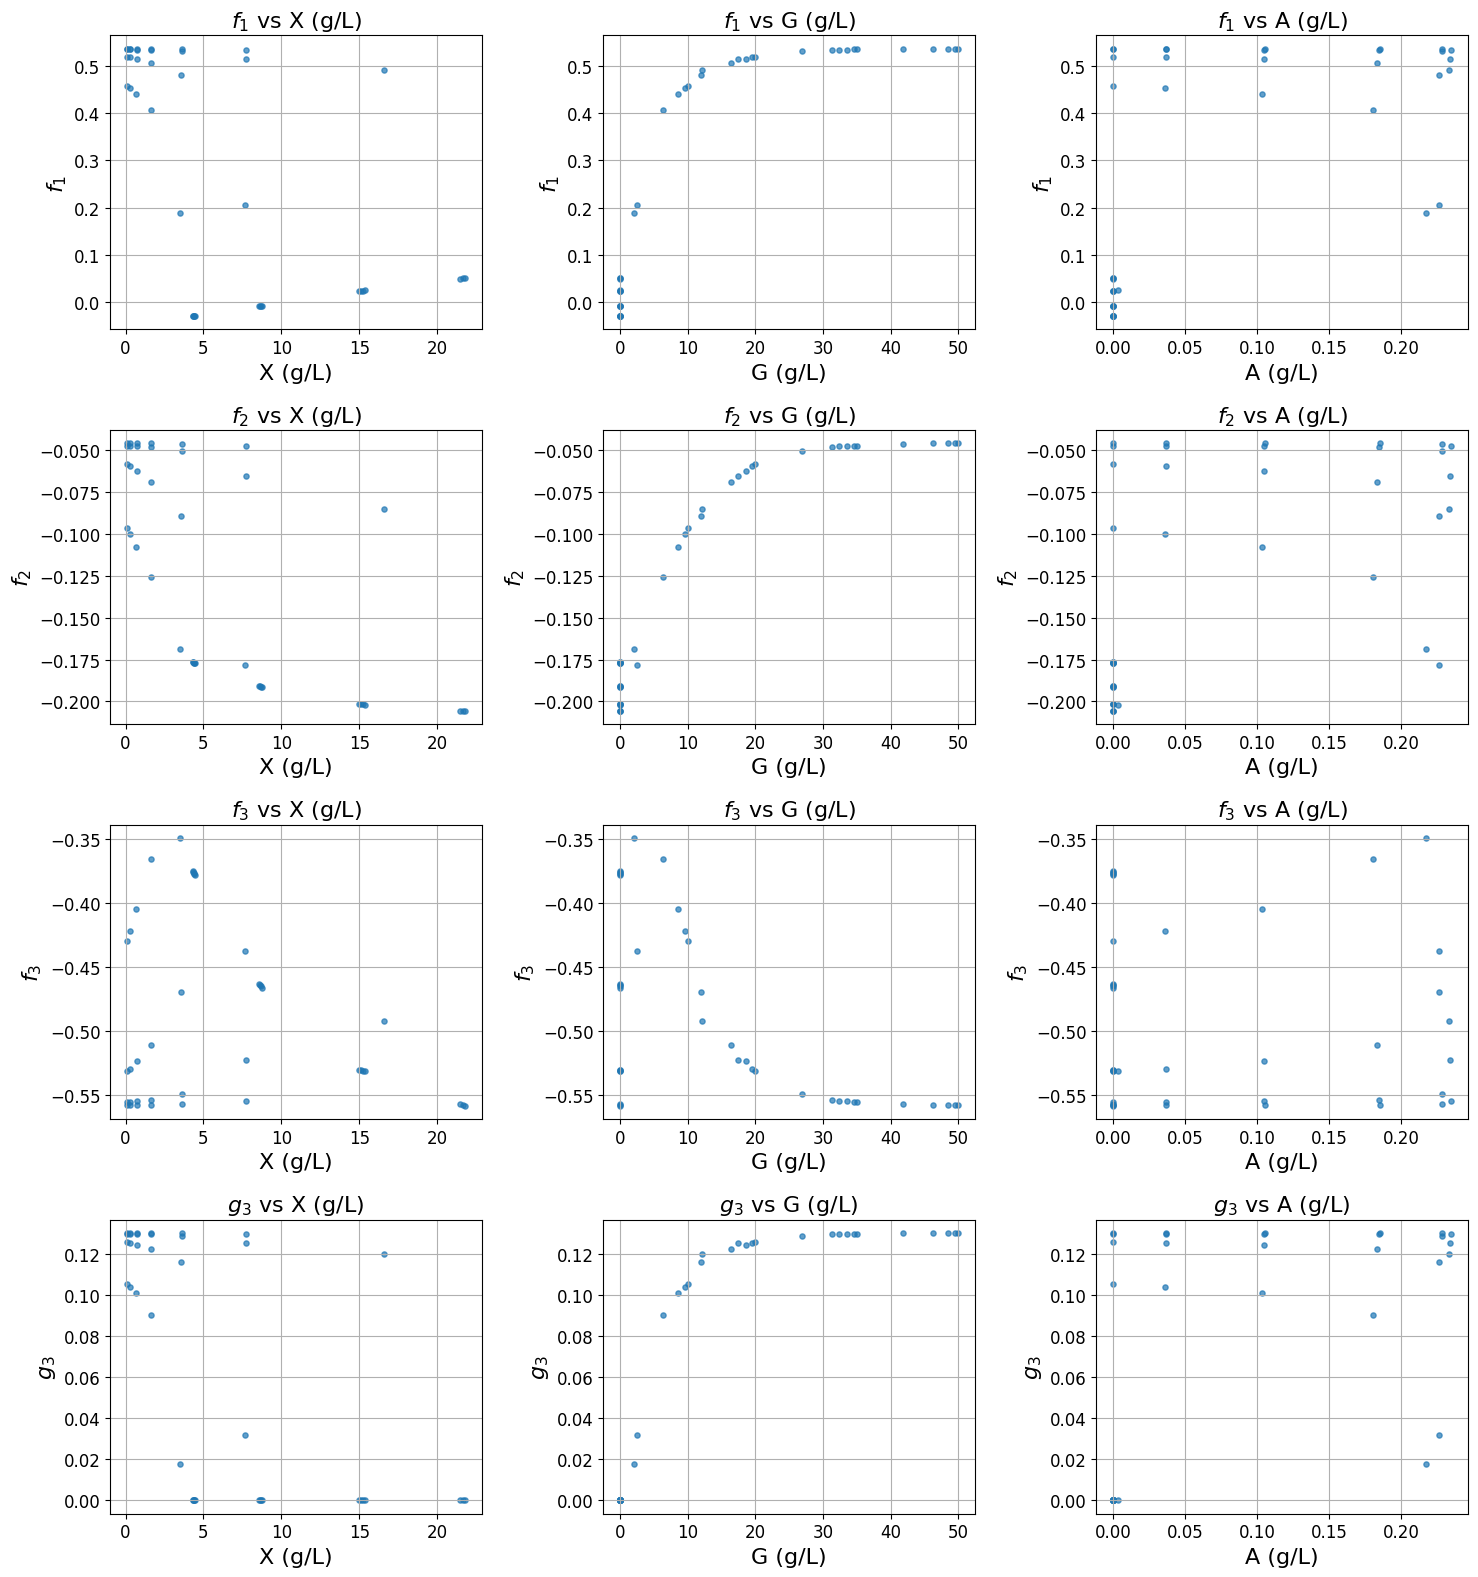

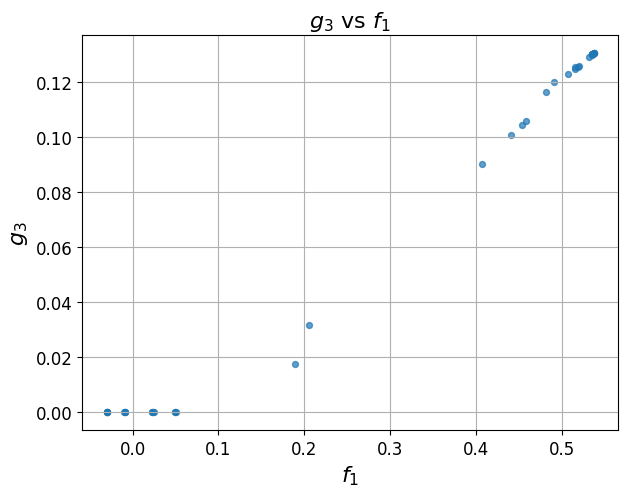

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

def plot_network_outputs_subset(params, neural_network, raw_X, raw_G, raw_A, idxs):
    """
    Visualize network outputs (f1, f2, f3, g3) against inputs (X, G, A),
    using ONLY the batches specified in `idxs` (e.g., train + validation).

    Args
    ----
    params : dict
        Must contain params["net"] (network weights).
    neural_network : function
        neural_network(net_params, y, train=False, masks=None) -> (f1,f2,f3,g3)
    raw_X, raw_G, raw_A : lists of batches (each batch = 1D array/list)
    idxs : list of int
        Indices of the batches to include (e.g., train_idxs + valid_idxs)
    """

    # ====== Larger fonts ======
    plt.rcParams.update({
        "font.size": 14,
        "axes.titlesize": 16,
        "axes.labelsize": 16,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
        "figure.titlesize": 18
    })

    # 1) Keep only selected batches
    X_sel = [raw_X[i] for i in idxs]
    G_sel = [raw_G[i] for i in idxs]
    A_sel = [raw_A[i] for i in idxs]

    # Flatten -> 1D arrays
    X_data = np.concatenate([np.asarray(b).ravel() for b in X_sel])
    G_data = np.concatenate([np.asarray(b).ravel() for b in G_sel])
    A_data = np.concatenate([np.asarray(b).ravel() for b in A_sel])

    # Remove NaNs
    mask = np.isfinite(X_data) & np.isfinite(G_data) & np.isfinite(A_data)
    X_data, G_data, A_data = X_data[mask], G_data[mask], A_data[mask]

    # 2) Batch evaluation via vmap
    net_params = params["net"]

    def _forward(y):
        return neural_network(net_params, y, train=False, masks=None)

    Y = jnp.stack([jnp.asarray(X_data), jnp.asarray(G_data), jnp.asarray(A_data)], axis=1)
    f1_vals, f2_vals, f3_vals, g3_raw = jax.vmap(_forward)(Y).T

    # ReLU for g3
    g3_vals = jnp.maximum(g3_raw, 0.0)

    # 3) Figure 1: Grid plots
    fig, axes = plt.subplots(4, 3, figsize=(15, 16), sharex=False, sharey=False)
    axes = np.asarray(axes)

    inputs = [(X_data, 'X (g/L)'), (G_data, 'G (g/L)'), (A_data, 'A (g/L)')]
    funcs = [
        (np.asarray(f1_vals), r'$f_1$'),
        (np.asarray(f2_vals), r'$f_2$'),
        (np.asarray(f3_vals), r'$f_3$'),
        (np.asarray(g3_vals), r'$g_3$')
    ]

    for row, (f_vals, f_label) in enumerate(funcs):
        for col, (inp_vals, xlabel) in enumerate(inputs):
            ax = axes[row, col]
            ax.scatter(inp_vals, f_vals, alpha=0.7, s=14)
            ax.set_xlabel(xlabel)
            ax.set_ylabel(f_label)
            ax.set_title(f'{f_label} vs {xlabel}')
            ax.grid(True)

    fig.tight_layout()
    plt.show()

    # 4) Figure 2: ReLU(g3) vs f1
    plt.figure(figsize=(6.5, 5.2))
    plt.scatter(np.asarray(f1_vals), np.asarray(g3_vals), alpha=0.7, s=18)
    plt.xlabel(r'$f_1$')
    plt.ylabel(r'$g_3$')
    plt.title(r'$g_3$ vs $f_1$')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


idxs = train_idxs + valid_idxs
plot_network_outputs_subset(best_params, neural_network, raw_X, raw_G, raw_A, idxs)


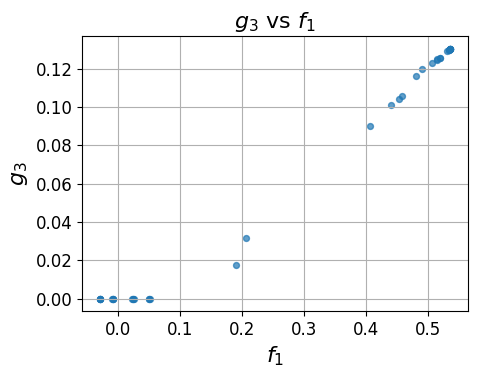

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved SVG to: g3_vs_f1.svg


In [ ]:
# ============================================================
# MINIMAL CODE: g3 vs f1 ONLY (SVG export, Colab-friendly)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from google.colab import files
import os

def plot_g3_vs_f1_and_save_svg(
    params,
    neural_network,
    raw_X,
    raw_G,
    raw_A,
    idxs,
    svg_name="g3_vs_f1.svg",
    download=True,
    save_dir=None
):
    """
    Plot g3 vs f1 using selected batches and save as SVG.

    Args
    ----
    params : dict
        Must contain params["net"] (network weights).
    neural_network : function
        neural_network(net_params, y, train=False, masks=None) -> (f1,f2,f3,g3)
    raw_X, raw_G, raw_A : lists of batches
    idxs : list of int
        Batch indices to include (e.g., train_idxs + valid_idxs)
    svg_name : str
        Name of SVG output file.
    download : bool
        If True, download SVG in Colab.
    save_dir : str or None
        Optional directory to save the SVG.
    """

    # ----------------------------
    # Collect selected data
    # ----------------------------
    X_sel = [raw_X[i] for i in idxs]
    G_sel = [raw_G[i] for i in idxs]
    A_sel = [raw_A[i] for i in idxs]

    X_data = np.concatenate([np.asarray(b).ravel() for b in X_sel])
    G_data = np.concatenate([np.asarray(b).ravel() for b in G_sel])
    A_data = np.concatenate([np.asarray(b).ravel() for b in A_sel])

    mask = np.isfinite(X_data) & np.isfinite(G_data) & np.isfinite(A_data)
    X_data, G_data, A_data = X_data[mask], G_data[mask], A_data[mask]

    # ----------------------------
    # Network evaluation (vmap)
    # ----------------------------
    net_params = params["net"]

    def _forward(y):
        return neural_network(net_params, y, train=False, masks=None)

    Y = jnp.stack(
        [jnp.asarray(X_data), jnp.asarray(G_data), jnp.asarray(A_data)],
        axis=1
    )

    f1_vals, _, _, g3_raw = jax.vmap(_forward)(Y).T
    g3_vals = jnp.maximum(g3_raw, 0.0)   # ReLU(g3)

    # ----------------------------
    # Plot: g3 vs f1
    # ----------------------------
    plt.figure(figsize=(5, 4))
    plt.scatter(
        np.asarray(f1_vals),
        np.asarray(g3_vals),
        alpha=0.7,
        s=18
    )
    plt.xlabel(r"$f_1$")
    plt.ylabel(r"$g_3$")
    plt.title(r"$g_3$ vs $f_1$")
    plt.grid(True)
    plt.tight_layout()

    # ----------------------------
    # Save SVG
    # ----------------------------
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        svg_path = os.path.join(save_dir, svg_name)
    else:
        svg_path = svg_name

    plt.savefig(svg_path, format="svg", bbox_inches="tight")
    plt.show()

    # ----------------------------
    # Download (Colab)
    # ----------------------------
    if download:
        files.download(svg_path)

    return svg_path


# ===========================
# USAGE
# ===========================
idxs = train_idxs + valid_idxs

svg_path = plot_g3_vs_f1_and_save_svg(
    params=best_params,
    neural_network=neural_network,
    raw_X=raw_X,
    raw_G=raw_G,
    raw_A=raw_A,
    idxs=idxs,
    svg_name="g3_vs_f1.svg",
    download=True,        # auto-download
    save_dir=None         # or e.g. "figures"
)

print("Saved SVG to:", svg_path)


### R² computation per batch

This code evaluates how well the trained model fits the data by computing the coefficient of determination (R²) **for each batch** and **for each state variable** (X, G, A).


In [ ]:
# ========================================================
# R^2 PER BATCH AND PER STATE (X, G, A)
# ========================================================
def r2_score_np(y_true, y_pred, eps=1e-12):
    """
    R^2 = 1 - SS_res / SS_tot.
    Returns np.nan if variance of y_true is ~0.
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    if ss_tot < eps:
        return np.nan
    return 1.0 - ss_res / ss_tot


def compute_r2_table(params_for_plot, split="train"):
    """
    Computes R^2 per batch and per state variable (X, G, A),
    and prints a formatted table.

    Parameters
    ----------
    params_for_plot : dict
        Parameter pytree (e.g., final 'params' or 'best_params')
    split : {"train", "valid", "test"}
        Dataset split to evaluate.

    Rules
    -----
    TRAIN:
        - Uses learned ICs (log-offsets).
        - A0 = 0.
    VALIDATION / TEST:
        - Uses measured ICs (first observed point).
        - A0 = 0.
    Predictions are evaluated at the observed time points.
    """

    # ----- Select dataset -----
    if split == "train":
        t_list, X_list, G_list, A_list = t_train, X_train, G_train, A_train
        idxs_in_original = train_idxs
        use_learned_ics = True
    elif split == "valid":
        t_list, X_list, G_list, A_list = t_valid, X_valid, G_valid, A_valid
        idxs_in_original = valid_idxs
        use_learned_ics = False
    elif split == "test":
        t_list, X_list, G_list, A_list = t_test, X_test, G_test, A_test
        idxs_in_original = test_idxs
        use_learned_ics = False
    else:
        raise ValueError("split must be 'train', 'valid', or 'test'")

    net_params = params_for_plot["net"]

    # ----- Helper functions -----
    def learned_ic_for_train_batch(params_local, train_pos):
        X0_meas = params_local["ic_meas"]["X0"][train_pos]
        G0_meas = params_local["ic_meas"]["G0"][train_pos]
        alpha_X = params_local["ic_alpha"]["alpha_X"][train_pos]
        alpha_G = params_local["ic_alpha"]["alpha_G"][train_pos]
        X0 = X0_meas * jnp.exp(alpha_X)
        G0 = G0_meas * jnp.exp(alpha_G)
        A0 = 0.0
        return float(X0), float(G0), float(A0)

    def measured_ic_from_data(X_obs_np, G_obs_np):
        X0 = float(X_obs_np[0])
        G0 = float(G_obs_np[0])
        A0 = 0.0
        return X0, G0, A0

    # ----- Compute R2 per batch -----
    rows = []

    for local_idx in range(len(t_list)):
        t_obs = np.array(t_list[local_idx])
        X_obs = np.array(X_list[local_idx])
        G_obs = np.array(G_list[local_idx])
        A_obs = np.array(A_list[local_idx])

        # Initial conditions
        if use_learned_ics:
            X0, G0, A0 = learned_ic_for_train_batch(params_for_plot, local_idx)
        else:
            X0, G0, A0 = measured_ic_from_data(X_obs, G_obs)

        # Predictions at observed times
        X_pred, G_pred, A_pred = predict(
            net_params,
            jnp.array(t_obs),
            X0,
            G0,
            A0=A0,
            train=False,
            masks=None
        )

        X_pred = np.array(X_pred)
        G_pred = np.array(G_pred)
        A_pred = np.array(A_pred)

        # R^2
        r2_X = r2_score_np(X_obs, X_pred)
        r2_G = r2_score_np(G_obs, G_pred)
        r2_A = r2_score_np(A_obs, A_pred)

        # Original batch number (1-based)
        orig_idx = idxs_in_original[local_idx]
        batch_number = orig_idx + 1

        # G0 from data
        G0_data = float(G_obs[0])

        rows.append((batch_number, G0_data, r2_X, r2_G, r2_A))

    # ----- Print formatted table -----
    print(f"\nR^2 per batch ({split.upper()}):")
    print("-" * 70)
    print(f"{'Batch':>5}  {'G0 [g/L]':>10}  {'R2_X':>10}  {'R2_G':>10}  {'R2_A':>10}")
    print("-" * 70)
    for (batch_number, G0_data, r2_X, r2_G, r2_A) in rows:
        print(f"{batch_number:5d}  {G0_data:10.4f}  {r2_X:10.4f}  {r2_G:10.4f}  {r2_A:10.4f}")
    print("-" * 70 + "\n")

    return rows


# Using best validation parameters
rows_train_b = compute_r2_table(best_params, split="train")
rows_valid_b = compute_r2_table(best_params, split="valid")
rows_test_b  = compute_r2_table(best_params, split="test")


R^2 per batch (TRAIN):
----------------------------------------------------------------------
Batch    G0 [g/L]        R2_X        R2_G        R2_A
----------------------------------------------------------------------
    1      9.9389      0.9703      0.9775      0.9737
    2     20.9241      0.9919      0.9906      0.9944
    4     49.4686      0.9927      0.9859      0.9741
----------------------------------------------------------------------


R^2 per batch (VALID):
----------------------------------------------------------------------
Batch    G0 [g/L]        R2_X        R2_G        R2_A
----------------------------------------------------------------------
    3     34.2896      0.9926      0.9862      0.9946
----------------------------------------------------------------------


R^2 per batch (TEST):
----------------------------------------------------------------------
Batch    G0 [g/L]        R2_X        R2_G        R2_A
----------------------------------------------------